In [1]:
# Training a small convnet from scratch to classify weather condition (i.e. cloudy, partly_cloudy, clear, haze)
# See: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
c:\users\me\appdata\local\temp\try_flags_slaxbu.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
data_dir = 'D:/Downloads/amazon/'
num_samples_per_epoch = 10000
# w/ 1000 samples per epoch, accuracy converges to about 0.74
# w/ 5000 samples per epoch, accuracy converges to about 0.82
# w/ 10000 samples per epoch, accuracy converges to about 0.87
# w/ 30000 , program freezes
num_epoch = 20
train_dir = data_dir + 'preprocess/train-jpg'
validation_dir = data_dir + 'preprocess/validation-jpg'
batch_size = 32
num_validations_per_epoch = 600
# all images will be resized to 128x128, which reduces number of pixels by 4x.
rescaled_dim = 128

In [3]:

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, rescaled_dim, rescaled_dim)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))  # we have 4 classes so we need 4 neurons
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',  # was binary_crossentropy
              optimizer='adagrad',
              metrics=['accuracy'])


In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True)  # TODO try vertical_flip=True

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of train_dir, and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(rescaled_dim, rescaled_dim),  
        batch_size=batch_size,
        class_mode='categorical')  # TODO 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode='categorical') # TODO

Found 32383 images belonging to 4 classes.
Found 8096 images belonging to 4 classes.


In [ ]:
# steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
# It should typically be equal to the number of unique samples of your dataset divided by the batch size.

history = model.fit_generator(
        train_generator,
        samples_per_epoch=num_samples_per_epoch, #  not using all training samples at every epoch.
        nb_epoch=num_epoch,
        validation_data=validation_generator,
        nb_val_samples=num_validations_per_epoch)
model.save(data_dir + 'models/model_first_try.h5')  # always save your model and weights after training or during training
print('done')

Epoch 1/20
 9984/10000 [============================>.] - ETA: 0s - loss: 0.7977 - acc: 0.7085  

C:\Users\Me\Anaconda2\lib\site-packages\keras\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10016/10000 [==============================] - 330s - loss: 0.7983 - acc: 0.7084 - val_loss: 0.7205 - val_acc: 0.6957
Epoch 2/20
10016/10000 [==============================] - 319s - loss: 0.6984 - acc: 0.7306 - val_loss: 0.6111 - val_acc: 0.7697

['acc', 'loss', 'val_acc', 'val_loss']


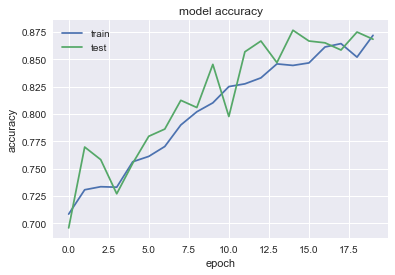

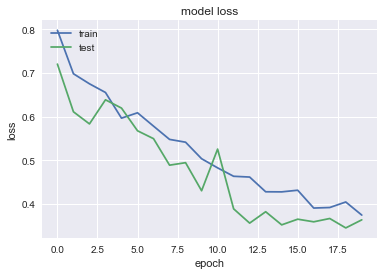

In [6]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [3]:
from keras.models import load_model
model = load_model(data_dir + 'models/model_first_try.h5')

In [8]:
number_of_predictions = 59 # must not be greater than the number of test images in the directory
# predict label for a set of handpicked test images
testset_datagen = ImageDataGenerator(rescale=1./255)

testset_dir = data_dir + 'preprocess/test'

testset_generator = testset_datagen.flow_from_directory(
        testset_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

#scoreSeg = model.evaluate_generator(testset_generator, 300)
#print("Accuracy = ",scoreSeg[1])
predict = model.predict_generator(testset_generator, number_of_predictions)
print(predict)


Found 59 images belonging to 1 classes.
[[  1.50683507e-01   4.12371665e-01   5.03422797e-01   4.19706181e-02]
 [  9.59432364e-01   1.64782163e-03   9.29956045e-03   2.52259299e-02]
 [  8.54783893e-01   9.61363257e-05   1.01260399e-03   8.81325360e-03]
 [  5.52037239e-01   1.64990649e-01   5.25151610e-01   1.28008872e-01]
 [  7.99115896e-01   3.00621893e-03   1.91470552e-02   2.43850462e-02]
 [  4.07375664e-01   1.18834361e-01   4.89681482e-01   1.13545462e-01]
 [  2.72355556e-01   4.94245410e-01   3.57900620e-01   6.39271080e-01]
 [  7.08105803e-01   4.92171431e-03   2.72117686e-02   4.49093953e-02]
 [  5.77768427e-04   8.46095085e-02   1.57112343e-04   9.99995232e-01]
 [  5.14843017e-02   5.17550349e-01   7.72889182e-02   9.57151413e-01]
 [  6.57107949e-01   1.05856946e-02   4.19265367e-02   7.63682052e-02]
 [  6.35760128e-02   8.25500523e-04   7.59477261e-04   8.50843310e-01]
 [  3.14467752e-06   3.64746228e-02   5.85879548e-07   1.00000000e+00]
 [  2.30104085e-02   9.23486710e-01  

In [9]:
print testset_generator.filenames

['test-001-jpg\\train_1022.jpg', 'test-001-jpg\\train_103.jpg', 'test-001-jpg\\train_11.jpg', 'test-001-jpg\\train_1147.jpg', 'test-001-jpg\\train_1232.jpg', 'test-001-jpg\\train_1384.jpg', 'test-001-jpg\\train_143.jpg', 'test-001-jpg\\train_1483.jpg', 'test-001-jpg\\train_1492.jpg', 'test-001-jpg\\train_1520.jpg', 'test-001-jpg\\train_1611.jpg', 'test-001-jpg\\train_162.jpg', 'test-001-jpg\\train_1663.jpg', 'test-001-jpg\\train_1711.jpg', 'test-001-jpg\\train_1738.jpg', 'test-001-jpg\\train_1786.jpg', 'test-001-jpg\\train_18.jpg', 'test-001-jpg\\train_1828.jpg', 'test-001-jpg\\train_194.jpg', 'test-001-jpg\\train_203.jpg', 'test-001-jpg\\train_2058.jpg', 'test-001-jpg\\train_2138.jpg', 'test-001-jpg\\train_215.jpg', 'test-001-jpg\\train_220.jpg', 'test-001-jpg\\train_2267.jpg', 'test-001-jpg\\train_23.jpg', 'test-001-jpg\\train_2504.jpg', 'test-001-jpg\\train_2516.jpg', 'test-001-jpg\\train_259.jpg', 'test-001-jpg\\train_26.jpg', 'test-001-jpg\\train_2632.jpg', 'test-001-jpg\\train_28

In [10]:
predictions_index = np.argmax(predict, axis=1)
print(predictions_index)

[2 0 0 0 0 2 3 0 3 3 0 3 3 1 3 1 0 3 3 1 2 0 2 2 1 0 1 3 3 3 3 0 1 3 0 3 3
 3 1 3 0 0 3 3 1 0 0 1 0 1 2 0 0 0 0 2 0 2 1]


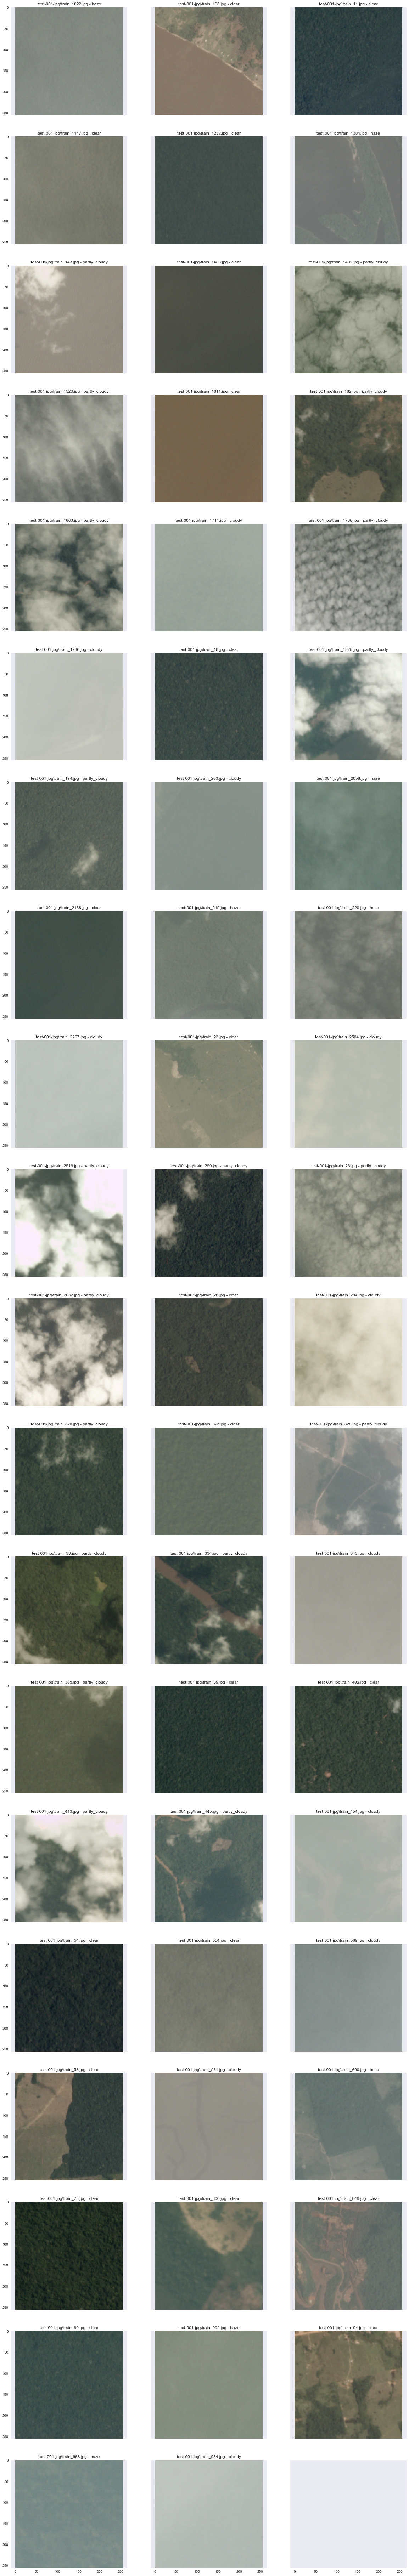

In [11]:
def int_to_label(index):
    labels = ['clear', 'cloudy', 'haze', 'partly_cloudy']
    return labels[index]

new_style = {'grid': False}
plt.rc('axes', **new_style)

num_cols = 3;
num_rows = int(np.ceil(number_of_predictions / num_cols)) + 1
#print(num_rows)

_, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,20*num_rows/num_cols))
i = 0
while i < predictions_index.size:
    file_path = testset_generator.filenames[i]
    #print(file_path)
    #print(testset_dir + '/' + file_path)
    img = cv2.imread(testset_dir + '/' + file_path)
    ax[i // num_cols, i % num_cols].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    label = int_to_label(predictions_index[i])
    ax[i // num_cols, i % num_cols].set_title('{} - {}'.format(file_path, label))
    i += 1
    
plt.show()

In [ ]:
#TODO: display the incorrectedly labeled test samples and inspect them to understand reason for misclassification.
#TODO: Show F-2 score http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
#      https://stats.stackexchange.com/questions/21551/how-to-compute-precision-recall-for-multiclass-multilabel-classification